In [1]:
%matplotlib notebook

In [2]:
path = "/Users/trinakarmakar/anaconda2/data/fastai/redux/sample/"

In [3]:
import utils
reload(utils)
from utils import plots

Using TensorFlow backend.


In [4]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [5]:
#As large as you can, but not larger than 64 is recommended
#If compute is running out this can be decreased

batch_size = 64
#import our class, and instantiate

from Vgg16 import Vgg16

In [6]:
vgg = Vgg16()
#grab few images from sample folder 
batches = vgg.get_batches(path+'train', batch_size = batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size = 2*batch_size)

vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Epoch 1/1
200/200 [==============================] - 608s - loss: 1.5856 - acc: 0.5150 - val_loss: 0.3045 - val_acc: 0.9200


In [7]:
#But with only imagenet model vgg16 isn't enough for our data as image net isn't trained with cats and dogs images.
#Lets work on the model for our data
vgg = Vgg16()
batches = vgg.get_batches(path+'train', batch_size=4) #grabing some images from training data

Found 200 images belonging to 2 classes.


In [8]:
imgs, labels = next(batches)

<IPython.core.display.Javascript object>


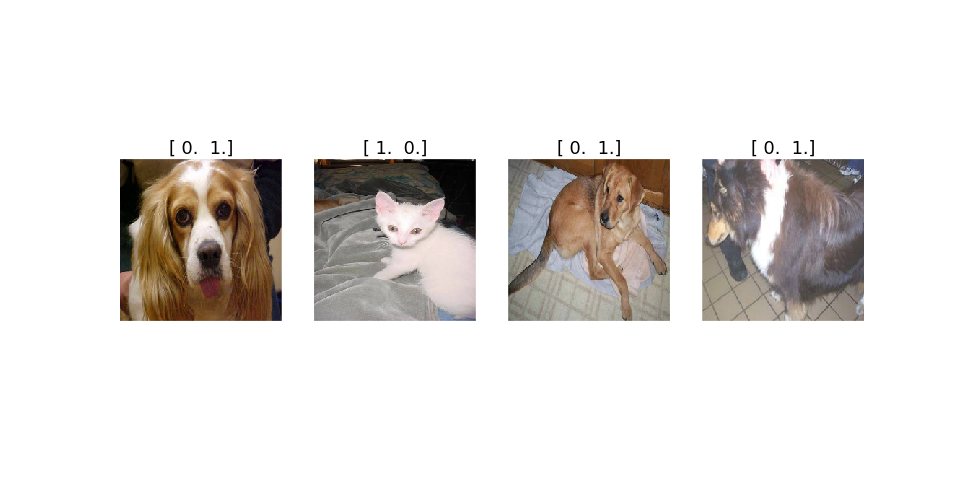

In [9]:
plots(imgs, titles=labels)

In [10]:
vgg.predict(imgs, True)

(array([ 0.5932,  0.2704,  0.4633,  0.2168], dtype=float32),
 array([151, 338, 163, 264]),
 [u'Chihuahua', u'guinea_pig', u'bloodhound', u'Cardigan'])

In [11]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

In [12]:
batch_size = 64

In [13]:
batches = vgg.get_batches(path+'train', batch_size = batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [14]:
vgg.finetune(batches)

In [16]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
200/200 [==============================] - 573s - loss: 1.6028 - acc: 0.4850 - val_loss: 0.3642 - val_acc: 0.8400


In [12]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [30]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [ ]:
classes[:5]

In [19]:
#Vgg model creation - define model and then load model weights

def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation= 'relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [24]:
#Fully connected block
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [25]:
#Vgg model was created by subtracting average of three R, G, B channels first, so that the data for each channel has mean zero.
#They also used tool where channels are in B, G , R not R, G, B which is python's defailt.
#So we need to make these two changes
#mean of each channel as provided in vgg model creators
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean  #subtract mean
    return x[:, ::-1]

In [32]:
#Now create vgg model

def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [33]:
model = VGG_16()

In [34]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [35]:
#grab a batch of images and predict on them...

def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True,
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                                   class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


<IPython.core.display.Javascript object>


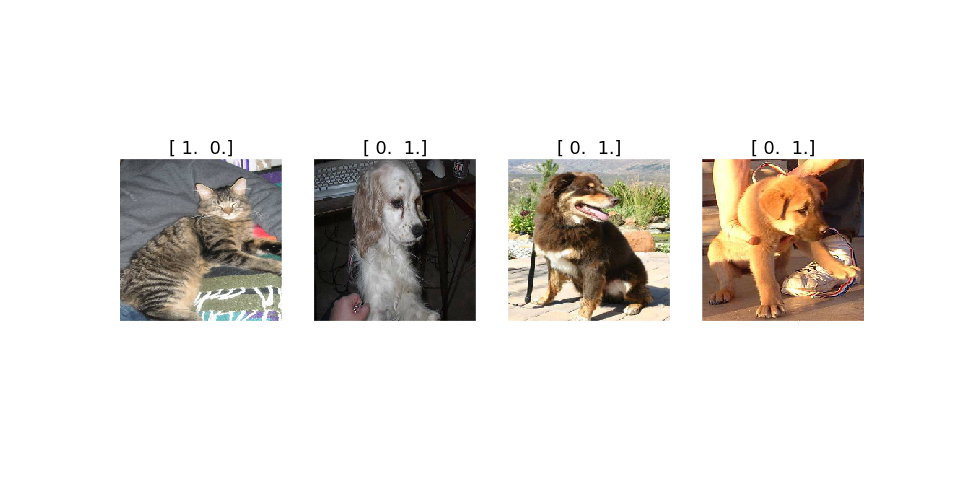

In [40]:
batch_size = 4
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs, labels = next(batches)

#This shows the "ground truth"
plots(imgs, titles=labels)

In [41]:
#Vgg model return 1000 probablity value for each image as it is trained with 1000 classes, we need to get the highest 

def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)
    
    print("Shape: {}".format(preds.shape))
    print("First 5 classes: {}".format(classes[:5]))
    print("First 5 probabilities: {}\n:".format(preds[0, :5]))
    print("Prediction prob/class: ")
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [42]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: [u'tench', u'goldfish', u'great_white_shark', u'tiger_shark', u'hammerhead']
First 5 probabilities: [  2.0501e-05   1.3007e-05   2.3701e-06   1.0737e-05   8.1578e-07]
:
Prediction prob/class: 
  0.6412/tabby
  0.8675/English_setter
  0.0784/Tibetan_mastiff
  0.3023/Chihuahua
